#4주차 과제 설명
<p>이번 과제의 목표는 세션 시간에 배운 Generation model 중 GAN을 직접 실습해보면서
supervisd learning과 다르게 discriminator와 generator를 어떻게 교대로 학습시켜야 하는지, 실제로 어떻게 이미지가 생성되는지 여러분들이 몸소 느끼시는 것입니다.</p>

<p>GAN을 직접 scratch부터 구현하는 것은 어려운 일이기에, 글로만 들었던 개념을 좀 더 상세히 코드로 이해하는데 중점을 두었습니다. 😂</p>

<p> 주어진 과제는 총 8개이며 훌륭한 교보재인 CS231 공식 assignment3을 대다수 참고하였습니다 🙇🏻‍♂️</p>

해당 과제는 런타임 연결시 'GPU' 사용을 강력히 권장드립니다!!

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# 본인의 다운로드받은 폴더경로에 맞게 설정해주시면 됩니다.
FOLDERNAME = "23_summer_cv/4th"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# dataset 경로 설정
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/23_summer_cv/4th/cs231n/datasets
bash: get_datasets.sh: No such file or directory
/content/drive/My Drive/23_summer_cv/4th


# Generative Adversarial Networks (GANs)


In [ ]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Help Functions 1
기본적인 전처리 함수들입니다

In [ ]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Dataset
 GPU 문제로부터 자유롭게 하기 위해 MNIST 데이터를 사용합니다 ^^

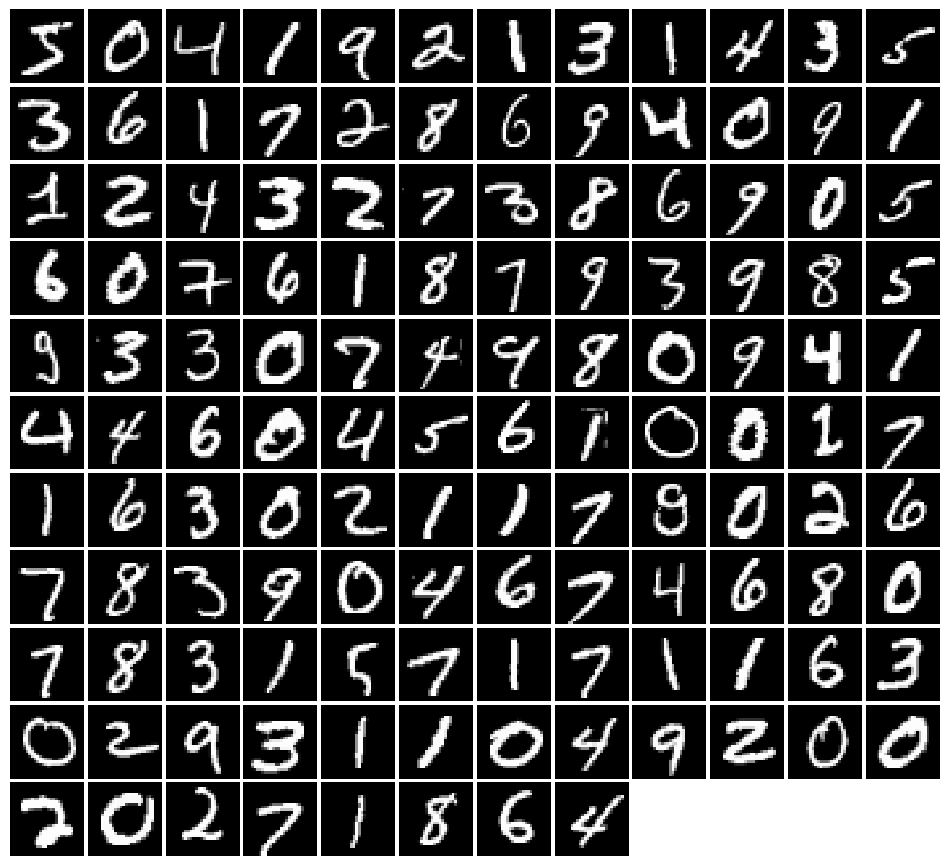

In [ ]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128


#MNIST data를 받을 경로설정을 각자 환경에 맞게 해주시면 됩니다
mnist_train = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    './cs231n/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise


# H.W 1 정답예시

In [ ]:
def sample_noise(batch_size, dim, seed=None):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    if seed is not None:
        torch.manual_seed(seed)

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return -2 * torch.rand(batch_size, dim) + 1

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [ ]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')

test_sample_noise()

All tests passed!


## Flatten & Unflatten & Weight initalization

여기서는 1차원의 벡터를 만들어주는 flatten 함수와 그 반대인 unflatten, 그리고  weight initializer로 자주 쓰이는 Xavier initalization을 소개합니다

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

# Discriminator

Discriminator는 아래와 같은 구조입니다.



 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1


*   마지막 output shape은 [batch_size, 1] 형태를 갖습니다






In [ ]:
def discriminator(seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, 1)
    )

    return model


In [ ]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


# Generator

Generator는 아래와 같은 구조입니다



 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])


In [ ]:
def generator(noise_dim=NOISE_DIM, seed=None):
    """
    Build and return a PyTorch model implementing the architecture above.
    """

    if seed is not None:
        torch.manual_seed(seed)

    model = None

    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 784),
        nn.Tanh()
    )

    return model

In [ ]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss


##   Generator Loss
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$ <br>

## Discriminator Loss
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$ <Br>

이 Loss들을 minimizing하기 위해 원래 Loss식에 -를 붙였습니다.

**HINTS**:

*   Discriminator logit ouput이 주어졌을때, true label에 대한 log probability를 계산하기 위해 Binary cross entropy를 이용해야합니다 (output이 P_data에서 나온 관측치인가?)
*   Binary cross entropy loss (s: score, y :label)

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$ <Br>

*   해당 식을 나이브하게 적용하면 unstable하기 때문에 아래의 bce 함수에 stable한 implementation을 제공하였습니다.
*   Loss 계산시, label들을 비교하시는 대상 logit size에 맞게 맞춰주시고, dtype을 이용해 correct data type으로 cast해주세요!!

`true_labels = torch.ones(size).type(dtype)`

* $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$ 의 expectation을 계산하는 방식이 아닌, minibatch 원소에 대해 averaging을 취하는 방식을 사용합니다.



Test your generator and discriminator loss. You should see errors < 1e-7.

# H.W 2 정답예시

GAN의 loss는 다음과 같습니다 <br>
원래는 둘다 gradient ascent를 사용하는 maximize형태이나,  -를 붙여줌으로써 minimize할 수 있도록 변경했습니다 <br>
generator loss:

$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
Discriminator loss:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$ <br>



*   해당 loss를 수식 그대로 naive하게 구현하는 방식은 numerically unstable해 stable한 다른 방식을 사용하는 방식을 제안합니다.
*   real image에 대한 label을 1, fake image에 대한 label을 0으로 두고 , logit argument를 통해 size를 결정합니다.


*   반드시 label과 score의 size를 맞춰줘야 합니다.
*   Log likelihood에 대한 expectation을 계산하지 않고, minibatch의 값에 대해 averaging을 취해 loss를 결합하는 방식을 사용합니다







In [ ]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss_fake = bce_loss(logits_fake, torch.zeros_like(logits_fake))
    loss_real = bce_loss(logits_real, torch.ones_like(logits_real)) #bce_loss (score, label)
    loss = loss_fake + loss_real

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = bce_loss(logits_fake, torch.ones_like(logits_fake))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss


In [ ]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_true']
)

Maximum error in d_loss: 3.97058e-09


In [ ]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss

# Training a GAN!



# H.W 3 정답예시


In [ ]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return optimizer


def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    images = []
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images

In [ ]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.458, G:0.6862
Iter: 250, D: 1.488, G:0.7073
Iter: 500, D: 1.376, G:1.239
Iter: 750, D: 1.272, G:1.225
Iter: 1000, D: 1.033, G:1.52
Iter: 1250, D: 1.116, G:1.356
Iter: 1500, D: 1.238, G:1.141
Iter: 1750, D: 1.279, G:1.154
Iter: 2000, D: 1.296, G:0.9389
Iter: 2250, D: 1.277, G:1.005
Iter: 2500, D: 1.327, G:0.8942
Iter: 2750, D: 1.275, G:0.9793
Iter: 3000, D: 1.236, G:0.7962
Iter: 3250, D: 1.262, G:0.9492
Iter: 3500, D: 1.258, G:0.8265
Iter: 3750, D: 1.388, G:0.9092


Run the cell below to show the generated images.

Iter: 0


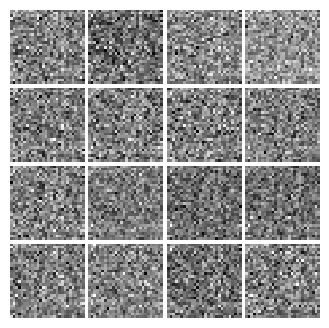


Iter: 250


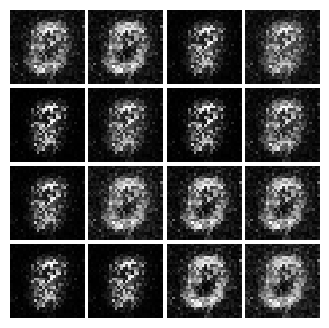


Iter: 500


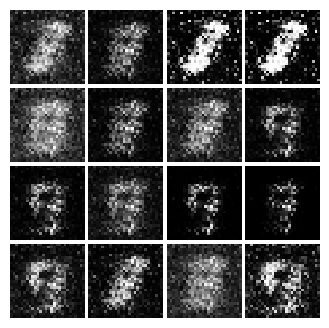


Iter: 750


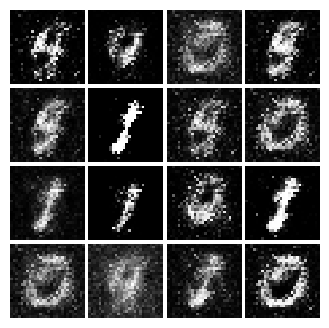


Iter: 1000


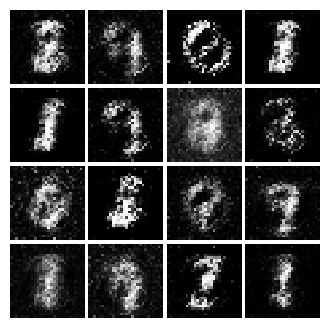


Iter: 1250


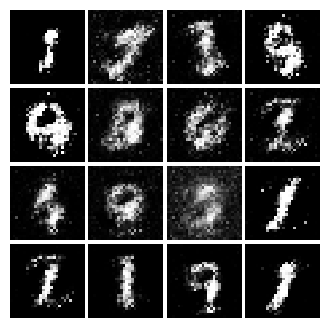


Iter: 1500


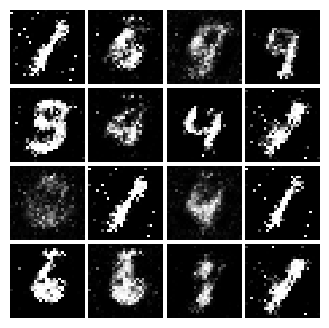


Iter: 1750


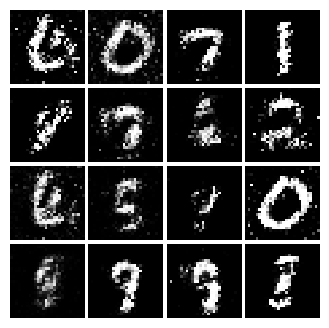


Iter: 2000


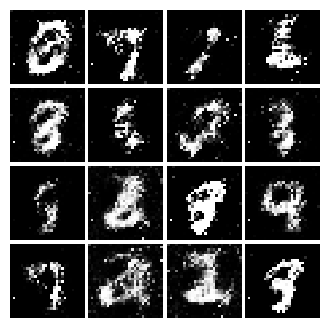


Iter: 2250


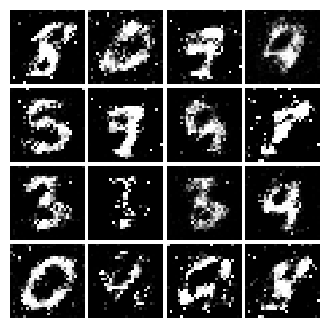


Iter: 2500


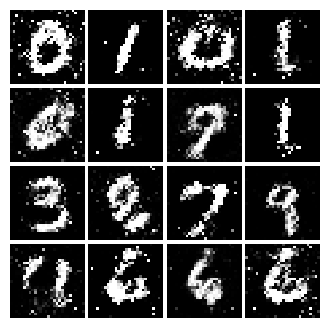


Iter: 2750


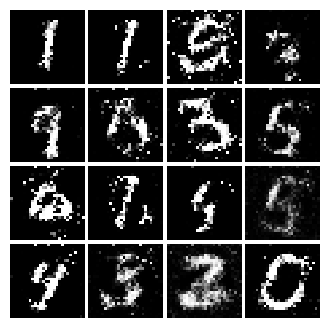


Iter: 3000


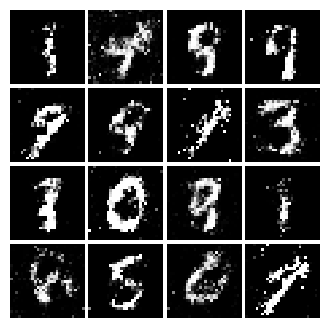


Iter: 3250


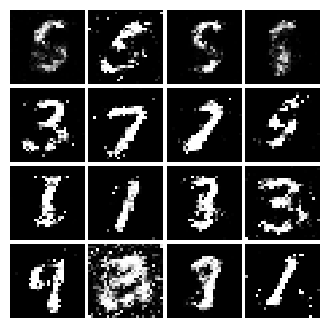


Iter: 3500


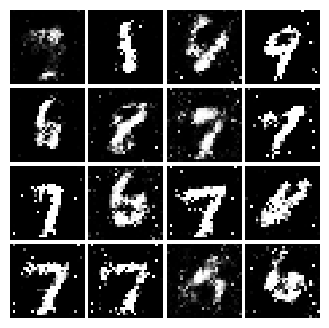


Iter: 3750


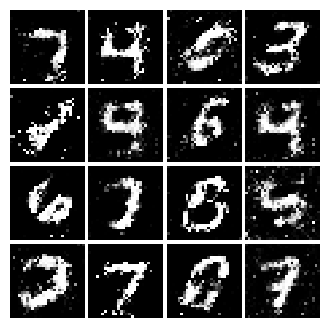

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

Vanilla GAN output image

Vanilla GAN final image:


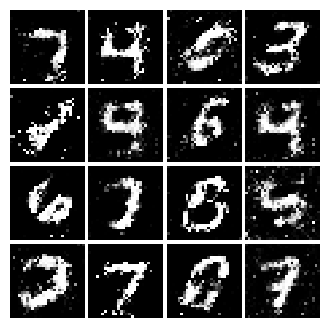

In [ ]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

# Least Squares GAN
LSGAN은 original GAN의 unstable loss function을 개선한 GAN입니다.
모델 구조는 바뀌지 않았지만 loss function이 이전과 다릅니다. <br>
[Least Squares GAN](https://arxiv.org/abs/1611.04076)



## Generation loss

$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$ <br>

## Discriminator loss
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$ <br>


*   앞의 Vanilla GAN loss와 마찬가지로 expectation을 계산하는 방식이 아닌, minibatch 원소에 대해 averaging을 취하는 방식을 사용합니다.

*    $D(x)$ and $D(G(z))$ 는 discriminator (`scores_real` and `scores_fake`).에서 나온 direct output을 사용합니다.



# H.W 4 정답예시

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * ((scores_real - 1).square() + scores_fake.square()).mean()

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.

    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5 * (scores_fake - 1).square().mean()

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

In [ ]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

In [ ]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Run the cell below to show generated images.

Iter: 0


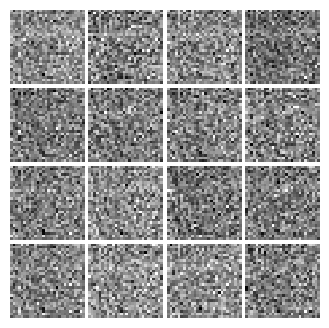


Iter: 250


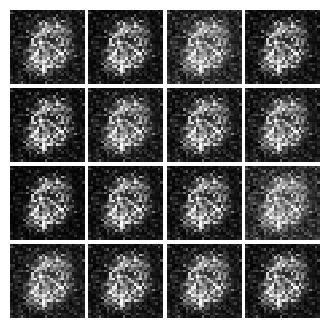


Iter: 500


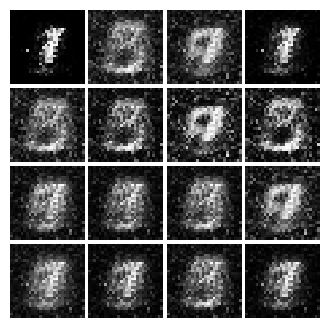


Iter: 750


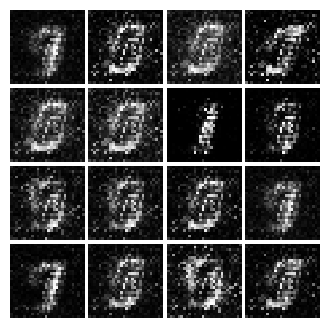


Iter: 1000


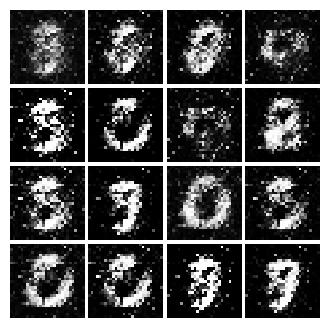


Iter: 1250


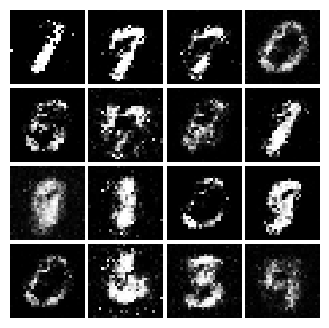


Iter: 1500


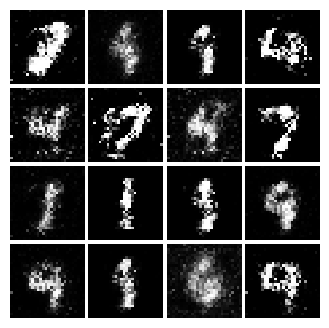


Iter: 1750


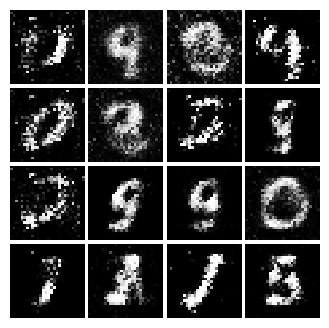


Iter: 2000


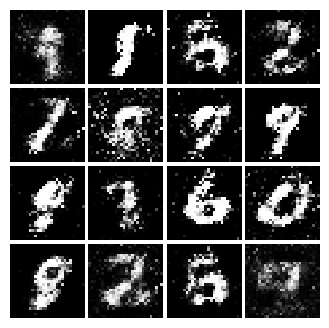


Iter: 2250


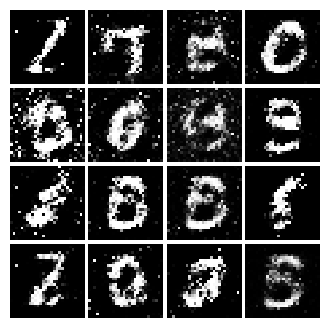


Iter: 2500


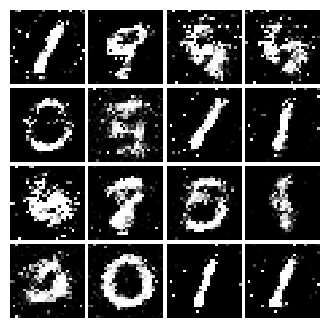


Iter: 2750


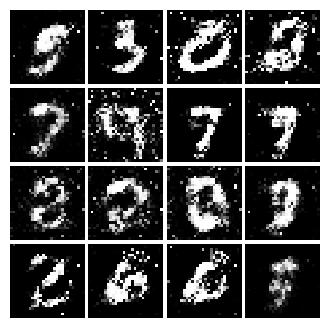


Iter: 3000


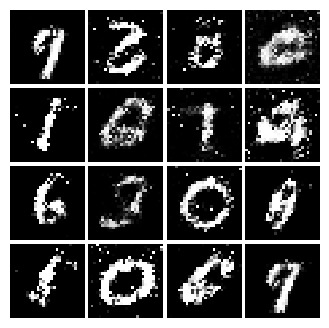


Iter: 3250


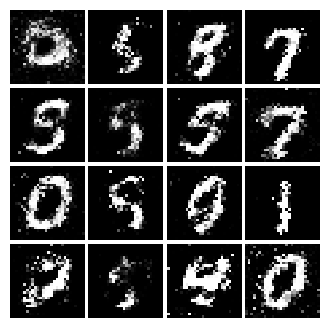


Iter: 3500


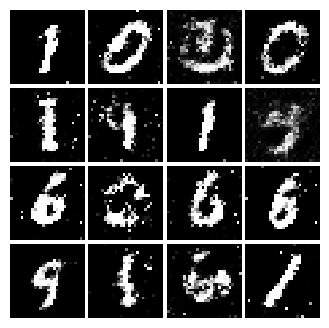


Iter: 3750


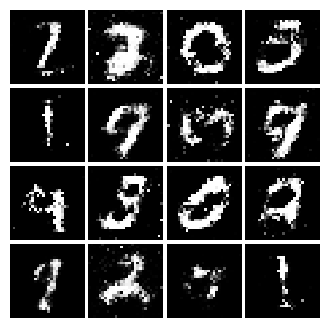

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

LSGAN output image

LSGAN final image:


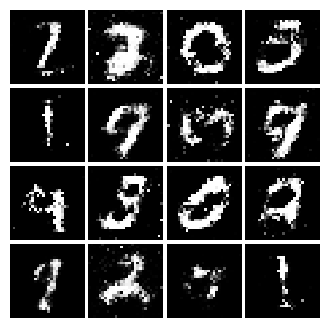

In [ ]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
Orginial GAN과 달리 Convolutional layer를 본격적으로 도입한 DCGAN을 만나보세요! <br>
[DCGAN](https://arxiv.org/abs/1511.06434)

#### Discriminator

아래의 Discriminator architecture를 코드로 짜주세요!


* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1


# H.W 5 정답예시

In [ ]:
def build_dc_classifier(batch_size):
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """

    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: nn.Sequential might be helpful.                                      #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return nn.Sequential(
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, 5, 1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 5, 1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(2, 2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(0.01),
        nn.Linear(4*4*64, 1)
    )

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [ ]:
data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [ ]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator
DCGAN에서 사용할 generator의 구조는  InfoGAN paper의 구조와 동일합니다 <br>
[InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). <br>
수업 시간에 말한 upsampling 기법도 transpose convolution으로 수행하니 아래의 architecture를 코드로 짜주세요!

* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector



#H.W 6 정답예시

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """

    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: nn.Sequential might be helpful.                                      #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        Unflatten(-1, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, 2, 1),
        nn.Tanh(),
        Flatten()
    )

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [ ]:
test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [ ]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [ ]:
D_DC = build_dc_classifier(batch_size).type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    num_epochs=5
)

DCGAN output image

DCGAN final image:


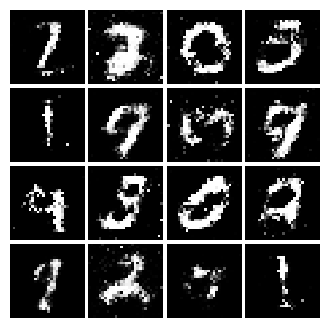

In [ ]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()